In [8]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import Libraries

In [9]:
import os
import torch

from dataclasses import asdict
from einops import rearrange, repeat

from flow_mnist.data import MNISTDataset
from flow_mnist.model import AutoEncoder
from flow_mnist.config import load_config
from flow_mnist.utils import plot_batch, image2norm, norm2image
from flow_mnist.flow import ProbPath, OTFlowPath
from flow_mnist.flow import MNISTImageSampleable, NormalSampleable, LambdaSampleable

Environment

In [10]:
torch.manual_seed(42)
os.chdir("..") if not os.path.exists("config.yaml") else None
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Project

In [11]:
config = load_config("config.yaml")
data = MNISTDataset(**asdict(config.data))

In [12]:
flow_path = OTFlowPath()
data_dist = MNISTImageSampleable(data)
norm_dist = NormalSampleable((3, 32, 32))
prob_path = ProbPath(f_path=flow_path, p_init=norm_dist, p_data=data_dist)

In [13]:
# x_0 ~ p_init & x_1 ~ p_data
t = repeat(torch.linspace(0, 1, 20), 't -> t 1 1 1')
x_0 = norm_dist.sample(1)
x_1 = data_dist.sample(1)

### Visualize Optimal Transport Path using $p_{init} = \mathcal{N}(0,1)$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.9523523..4.1205125].


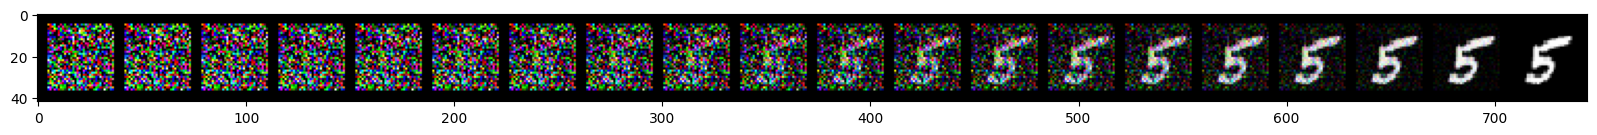

In [14]:
# p_init in [-1, 1] -> p_data in [0, 1]
x_t = prob_path.cond_prob_path(x_1, t)
plot_batch(x_t, nrow=t.size(0), figsize=(20, 5))

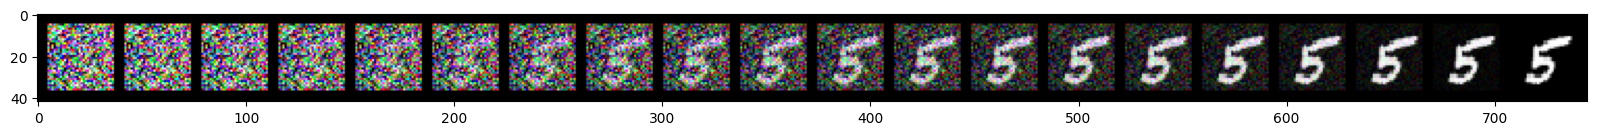

In [15]:
# p_init in [-1, 1] -> p_data in [-1, 1]
x_1_norm = image2norm(x_1)
x_t = prob_path.flow(x_0, x_1_norm, t)
x_t = norm2image(x_t)
plot_batch(x_t, nrow=t.size(0), figsize=(20, 5))

### Visualize Optimal Transport Path using AutoEncoderKL Latents

In [16]:
# Loade vae and create preprocessing function
vae = AutoEncoder(**asdict(config.model.vae)).to(device)
encode_image = lambda x: vae.encode(x.to(device))

# Create distributions
x_1 = torch.cat([x_1, data_dist.sample(7)], dim=0)
x_1_latent = encode_image(x_1)
latent_norm_dist = NormalSampleable(x_1_latent.shape[1:])
latent_data_dist = LambdaSampleable(data_dist, encode_image)

# Create ot prob path
prob_path = ProbPath(f_path=flow_path, p_init=latent_norm_dist, p_data=latent_data_dist)

Sample one latent and vizualize the conditional probability path $p_t(x|z)$

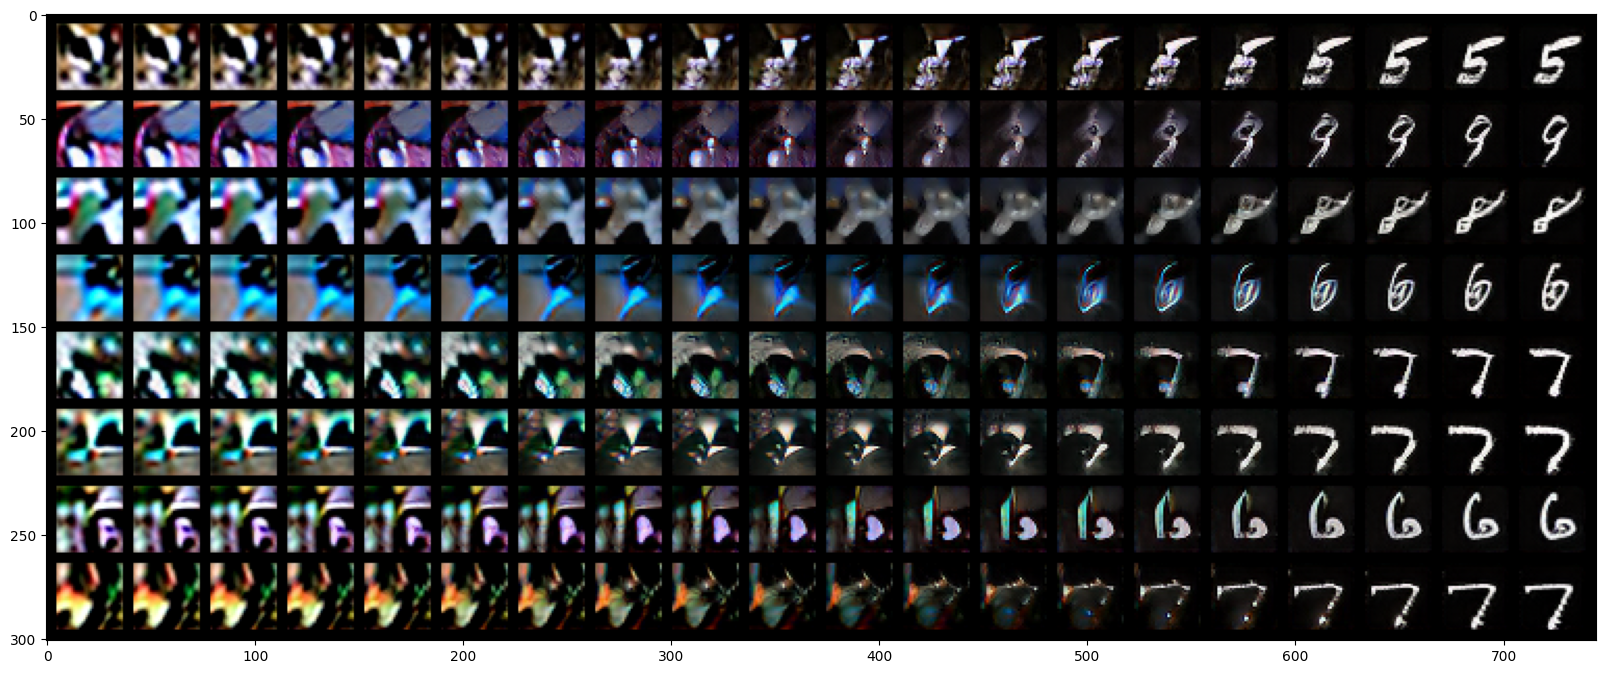

In [17]:
x_t_latent = prob_path.cond_prob_path(x_1=x_1_latent, t=t.unsqueeze(-1).to(device))
x_t_latent = rearrange(x_t_latent, 't b c h w -> (b t) c h w')
x_t = vae.decode(x_t_latent).cpu()
plot_batch(x_t, nrow=t.size(0), figsize=(20, 10))

Sample from the marginal probability path $p_t(x)$

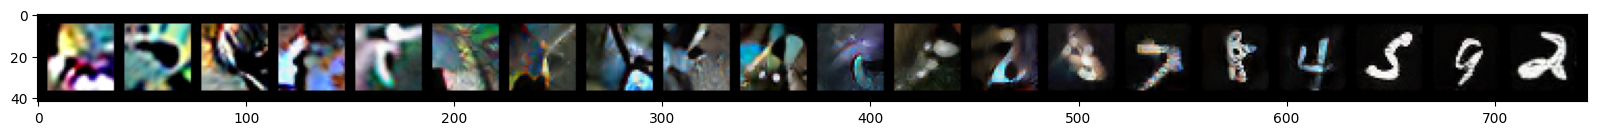

In [18]:
x_t_latent = prob_path.marg_prob_path(t=t.to(device))
x_t = vae.decode(x_t_latent).cpu()
plot_batch(x_t, nrow=t.size(0), figsize=(20, 5))